## SI 671 Homework 2
uniqname: Yipeng Chen

In [30]:
import pandas as pd
import keras
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

ignore warnings for training.

### 1. Data reading
I don't think I'm very care about how many documentations and how many sentences they have. Just get the data...

In [4]:
def read_data(path):
    res = []
    doc_num = 0
    with open(path, 'r') as fr:
        for line in fr.readlines():
            if line == '-DOCSTART- -X- O O\n':
                doc_num += 1
            elif line != '\n' and line != '-DOCSTART- -X- O O\n':
                res.append([doc_num] + line.split())
        df = pd.DataFrame(res, columns=['doc_num', 'word', 'pos', 'chunking', 'tag'])

    return df
            

In [5]:
# read data
path = './DataNer.txt'
df = read_data(path)

In [6]:
df.head()

,doc_num,word,pos,chunking,tag
0,1,He,PRP,I-NP,O
1,1,said,VBD,I-VP,O
2,1,further,JJ,I-NP,O
3,1,scientific,JJ,I-NP,O
4,1,study,NN,I-NP,O


In [7]:
df.iloc[:, 1:].describe()

,word,pos,chunking,tag
count,207270,207270,207270,207270
unique,23825,45,17,8
top,.,NNP,I-NP,O
freq,7486,35159,122477,172494


In [8]:
df.doc_num.max()

960

In [9]:
df.shape

(207270, 5)

Here we do a little bit data interpretations here. 
1. We can see that we have 8 unique values for label and 'O' has the most of the value.
2. We have 46 different unique values of pos and 17 unique values of chunking_tag
3. We have 207270 rows and 23825 unique word.
4. We have 960 different docs.

### 2. Data handling
1. one hot encoding
2. prepare train and test data
3. prepare class list without 'O' tag

In [10]:
# one hot encoding
df_dict = df[['word', 'pos', 'chunking']].to_dict("record")
from sklearn.feature_extraction import DictVectorizer
vector = DictVectorizer(sparse=True)
X = vector.fit_transform(df_dict)

In [11]:
# train_test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['tag'].values, test_size = 0.3, random_state=0)

In [12]:
# class list without 'O'
class_list = df.tag.unique().tolist()[1:]

### explaination
1. For most of the data, what we want is a sparse vector so that the training would be faster, so I use DictVectorizer to on onehot encoding.
2. Then we do the train_test split in order to do training and inference.
3. Also, we need to filter 'O' for classification report

## 3. Model training

In [21]:
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score

### SGD Linear Classifier

In [13]:
alpha_list = [1000, 2000]
best_score = 0
best_iter = 0
best_pred = []
for i in alpha_list:
    model = linear_model.SGDClassifier(max_iter=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tmp_score = f1_score(y_test, y_pred, average='weighted')
    if tmp_score > best_score:
        best_score = tmp_score
        best_pred = y_pred
        best_iter = i
        
result = classification_report(y_pred=best_pred, y_true=y_test, labels=class_list)
print('f1 score: ', best_score)
print('best iter: ', best_iter)
print('report: \n', result)

f1 score:  0.9482309264147721
best iter:  1000
report: 
               precision    recall  f1-score   support

       I-ORG       0.86      0.60      0.71      3078
       I-PER       0.73      0.94      0.82      3498
      I-MISC       0.88      0.57      0.69      1381
       I-LOC       0.87      0.73      0.80      2497
       B-LOC       1.00      0.60      0.75         5
      B-MISC       0.00      0.00      0.00        12
       B-ORG       0.25      1.00      0.40         7

   micro avg       0.80      0.74      0.77     10478
   macro avg       0.66      0.63      0.60     10478
weighted avg       0.82      0.74      0.76     10478



### Explaination
1. We apply SGD classifier with (1000, 2000) max iteration.
2. We find that 1000 is the better than 2000
3. f1 score is 0.94, which is good.

### Multinomial Naive Bayes Model Classifier

In [14]:
alpha_list = [0.1, 1, 10]
best_score = 0
best_alpha = 0
best_pred = []
for i in alpha_list:
    model = MultinomialNB(alpha=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tmp_score = f1_score(y_test, y_pred, average='weighted')
    if tmp_score > best_score:
        best_score = tmp_score
        best_pred = y_pred
        best_alpha = i
        
result = classification_report(y_pred=best_pred, y_true=y_test, labels=class_list)
print('f1 score: ', best_score)
print('best alpha: ', best_alpha)
print('report: \n', result)

f1 score:  0.9537495610142331
best alpha:  0.1
report: 
               precision    recall  f1-score   support

       I-ORG       0.86      0.70      0.77      3078
       I-PER       0.73      0.96      0.83      3498
      I-MISC       0.65      0.78      0.71      1381
       I-LOC       0.86      0.81      0.83      2497
       B-LOC       0.00      0.00      0.00         5
      B-MISC       0.00      0.00      0.00        12
       B-ORG       0.00      0.00      0.00         7

   micro avg       0.78      0.82      0.80     10478
   macro avg       0.44      0.46      0.45     10478
weighted avg       0.79      0.82      0.80     10478



### Explaination
1. We apply MultinomialNB classifier with (0.1, 1, 10) alpha.
2. We find that 0.1 is the better than others
3. f1 score is 0.953, which is good.

### Perceptron Classifier

In [15]:
alpha_list = [1e-6, 1e-5, 1e-4]
best_score = 0
best_alpha = 0
best_pred = []
for i in alpha_list:
    model = linear_model.Perceptron(alpha=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tmp_score = f1_score(y_test, y_pred, average='weighted')
    if tmp_score > best_score:
        best_score = tmp_score
        best_pred = y_pred
        best_alpha = i
        
result = classification_report(y_pred=best_pred, y_true=y_test, labels=class_list)
print('f1 score: ', best_score)
print('best alpha: ', best_alpha)
print('report: \n', result)

f1 score:  0.9428234857389134
best alpha:  1e-06
report: 
               precision    recall  f1-score   support

       I-ORG       0.96      0.47      0.63      3078
       I-PER       0.99      0.65      0.78      3498
      I-MISC       0.83      0.78      0.81      1381
       I-LOC       0.50      0.95      0.65      2497
       B-LOC       0.80      0.80      0.80         5
      B-MISC       0.00      0.00      0.00        12
       B-ORG       0.05      1.00      0.09         7

   micro avg       0.72      0.69      0.70     10478
   macro avg       0.59      0.66      0.54     10478
weighted avg       0.84      0.69      0.71     10478



### Explaination
1. We apply MultinomialNB classifier with (1e-6, 1e-5, 1e-4) alpha.
2. We find that 1e-6 is the better than others
3. f1 score is 0.94, which is good.

### Conditional Random Fields

In [16]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [30]:
df.head()

,doc_num,word,pos,chunking,tag
0,1,He,PRP,I-NP,O
1,1,said,VBD,I-VP,O
2,1,further,JJ,I-NP,O
3,1,scientific,JJ,I-NP,O
4,1,study,NN,I-NP,O


In [31]:
group_doc = df.groupby('doc_num').apply(lambda s: [(a, b, c) for a, b, c in zip(s.word.values.tolist(), 
                                                   s.pos.values.tolist(), 
                                                   s.tag.values.tolist())])
docs = [s for s in group_doc]

X = [sent2features(s) for s in docs]
y = [sent2labels(s) for s in docs]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
alpha_list = ['lbfgs', 'l2sgd']
best_score = 0
best_alpha = ''
best_pred = []
for i in alpha_list:
    model = CRF(algorithm=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tmp_score = flat_f1_score(y_test, y_pred, average='weighted')
    if tmp_score > best_score:
        best_score = tmp_score
        best_pred = y_pred
        best_alpha = i
        
result = flat_classification_report(y_pred=best_pred, y_true=y_test, labels=class_list)
print('f1 score: ', best_score)
print('best algorithm: ', best_alpha)
print('report: \n', result)

f1 score:  0.9677881176213229
best algorithm:  lbfgs
report: 
               precision    recall  f1-score   support

       I-ORG       0.84      0.77      0.81      3079
       I-PER       0.87      0.92      0.89      3302
      I-MISC       0.88      0.76      0.82      1366
       I-LOC       0.86      0.87      0.87      2516
       B-LOC       0.00      0.00      0.00        10
      B-MISC       1.00      0.20      0.33        10
       B-ORG       0.00      0.00      0.00         0

   micro avg       0.86      0.84      0.85     10283
   macro avg       0.64      0.50      0.53     10283
weighted avg       0.86      0.84      0.85     10283



1. Here we regard documents as a seperator.
2. We group by the docs and then generate training and test data set. (With use of word2features and so on)
3. Then we apply CRF model to train in inference the model.
4. f1 score is 0.967, which is good.

### LSTM-CRF

In [13]:
words = list(set(df["word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

23826

In [51]:
tags = list(set(df["tag"].values))
n_tags = len(tags); n_tags

8

In [15]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
# get sentence 
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("doc_num").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
getter = SentenceGetter(df)
sent = getter.get_next()
sentences = getter.sentences

In [20]:
max_len = max([len(s) for s in sentences])

from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [21]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

In [22]:
import keras
print(keras.__version__)

2.2.4


In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [25]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
model = Model(input, out)

In [27]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1335)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1335, 20)          476540    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1335, 100)         28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1335, 50)          5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 1335, 8)           488       
Total params: 510,478
Trainable params: 510,478
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)


Train on 604 samples, validate on 68 samples
Epoch 1/5
604/604 [==============================] - 36s 59ms/step - loss: 0.9533 - crf_viterbi_accuracy: 0.6655 - val_loss: 0.1435 - val_crf_viterbi_accuracy: 0.9753
Epoch 2/5
604/604 [==============================] - 34s 56ms/step - loss: 0.1496 - crf_viterbi_accuracy: 0.9722 - val_loss: 0.1258 - val_crf_viterbi_accuracy: 0.9753
Epoch 3/5
604/604 [==============================] - 35s 59ms/step - loss: 0.1357 - crf_viterbi_accuracy: 0.9721 - val_loss: 0.1054 - val_crf_viterbi_accuracy: 0.9753
Epoch 4/5
604/604 [==============================] - 33s 55ms/step - loss: 0.1146 - crf_viterbi_accuracy: 0.9724 - val_loss: 0.1002 - val_crf_viterbi_accuracy: 0.9753
Epoch 5/5
604/604 [==============================] - 34s 56ms/step - loss: 0.1064 - crf_viterbi_accuracy: 0.9724 - val_loss: 0.0990 - val_crf_viterbi_accuracy: 0.9753


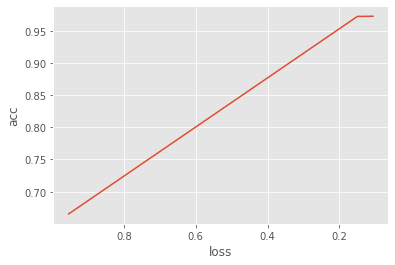

In [47]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.gca()
ax.invert_xaxis()
plt.style.use("ggplot")
plt.xlabel('loss')
plt.ylabel('acc')
plt.plot(hist["loss"],hist["crf_viterbi_accuracy"],)
plt.show()

In [65]:
idx2tag

{0: 'I-LOC',
 1: 'I-ORG',
 2: 'B-LOC',
 3: 'B-MISC',
 4: 'I-MISC',
 5: 'B-ORG',
 6: 'I-PER',
 7: 'O'}

In [75]:
# Evaluation
from sklearn.metrics import classification_report, f1_score

test_pred = model.predict(X_te, verbose=1)
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)
pred_labels = sum(pred_labels, [])
test_labels = sum(test_labels, [])

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels,average='weighted')))
print(classification_report(test_labels, pred_labels))

288/288 [==============================] - 3s 12ms/step
F1-score: 96.0%
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00        10
      B-MISC       0.00      0.00      0.00        10
       I-LOC       0.00      0.00      0.00      2516
      I-MISC       0.00      0.00      0.00      1366
       I-ORG       0.00      0.00      0.00      3079
       I-PER       0.00      0.00      0.00      3302
           O       0.97      1.00      0.99    374197

    accuracy                           0.97    384480
   macro avg       0.14      0.14      0.14    384480
weighted avg       0.95      0.97      0.96    384480



1. Here we regard documents as a seperator.
2. We group by the docs and then generate training and test data set. (With use of SentenceGetter and so on). Here my doc means sentence instead.
3. Then we use keras to apply Bidirectional LSTM-CRF model to train in inference the model.
4. f1 score is 0.96, which is good. But notice that for classification report, only 'O' has big acc and recall, which is bad. There may be some overfitting problem.